In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.rcParams['figure.figsize']=[15,5]
pd.options.plotting.backend = "plotly"


In [7]:
url = "https://raw.githubusercontent.com/Patrick-David/Stocks_Significance_PHacking/master/spx.csv"
df = pd.read_csv(url,index_col='date', parse_dates=True)

#view raw S&P500 data
df.head()


,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [8]:
df.plot.line(y='close')

In [9]:
daily_ret = df['close'].pct_change()
#drop the 1st value - nan
daily_ret.dropna(inplace=True)
#daily %change
daily_ret.head()


date
1986-01-03    0.006155
1986-01-06   -0.001091
1986-01-07    0.014954
1986-01-08   -0.027268
1986-01-09   -0.008944
Name: close, dtype: float64

In [19]:
#use pandas to resample returns per month and take Standard Dev as measure of Volatility
#then annualize by multiplying by sqrt of number of periods (12)
mnthly_annu = daily_ret.resample('M').std()* np.sqrt(12)


date
1986-01-31    0.033317
1986-02-28    0.023585
1986-03-31    0.027961
1986-04-30    0.037426
1986-05-31    0.027412
Freq: M, Name: close, dtype: float64


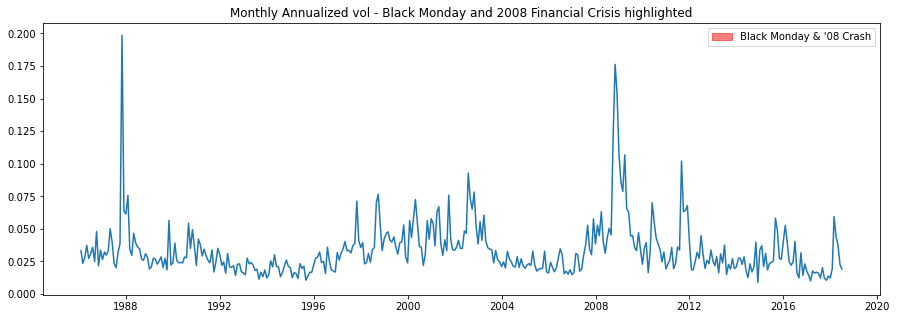

In [22]:
print(mnthly_annu.head())
#we can see major market events show up in the volatility
plt.plot(mnthly_annu)
# plt.axvspan('1987','1989',color='r',alpha=.5)
# plt.axvspan('2008','2010',color='r',alpha=.5)
plt.title('Monthly Annualized vol - Black Monday and 2008 Financial Crisis highlighted')
labs = mpatches.Patch(color='red',alpha=.5, label="Black Monday & '08 Crash")
plt.legend(handles=[labs])


So we've seen one of the powerful methods in pandas, resample. Now, let's use another, 'groupby'. We need to get from our monthly annualized volatility values to our desired AMVR metric. Again, we can achieve this in just a few lines of code.

 1. First, we apply the 'groupby' method to our mnthly_annu values. Groupby requires a parameter that specifies how to group the data. This could be a function or as in our case, a Series. We pass in 'mnthly_annu.index.year', this is simply the year attribute on the datatime index of the mnthly_annu data. This will group our monthly volatility values for each of the 32 years in our data set.

 2. Next, we apply the 'rank' method, which orders the data in ascending order.

 3. Finally, we do the same thing again and average over all years for each month. This gives us our final AMVR values!

In [24]:
#for each year rank each month based on volatility lowest=1 Highest=12
ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()

#average the ranks over all years for each month
final = ranked.groupby(ranked.index.month).mean()

final.describe()


count    12.000000
mean      6.450521
std       0.627458
min       5.218750
25%       6.031013
50%       6.491004
75%       6.704545
max       7.531250
Name: close, dtype: float64

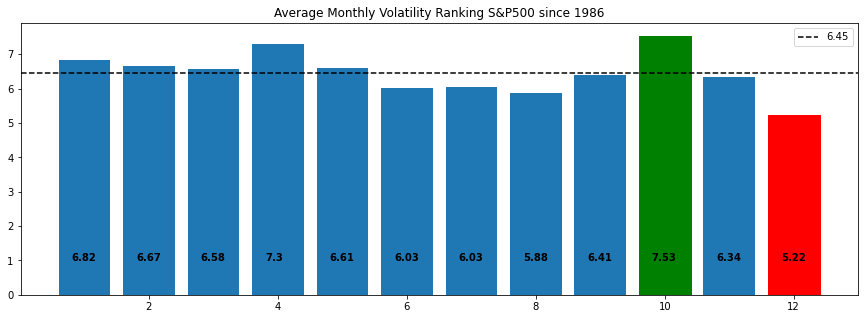

In [28]:
b_plot = plt.bar(x=final.index,height=final)
b_plot[9].set_color('g')
b_plot[11].set_color('r')
for i,v in enumerate(round(final,2)):
    plt.text(i+.8,1,str(v), color='black', fontweight='bold')
plt.axhline(final.mean(),ls='--',color='k',label=round(final.mean(),2))
plt.title('Average Monthly Volatility Ranking S&P500 since 1986')

plt.legend()
plt.show()

Choose an appropriate ‘test statistic’: this is simply a number that measures the observed effect. In our case, we will choose the absolute deviation in AMVR from the mean.

Construct a Null Hypothesis: this is merely a version of the data where the observed effect is not present. In our case, we will shuffle the labels of the data repeatedly (permutation). The justification for this is detailed below.

Compute a p-value: this is the probability of seeing the observed effect amongst the null data, in other words, by chance. We do this through repeated simulation of the null data. In our case, we shuffle the ‘date’ labels of the data many times and simply count the occurrence of our test statistic as it appears through multiple simulations.


In [40]:
final

date
1     6.818182
2     6.666667
3     6.575758
4     7.303030
5     6.606061
6     6.030303
7     6.031250
8     5.875000
9     6.406250
10    7.531250
11    6.343750
12    5.218750
Name: close, dtype: float64

In [33]:
#take abs value move from the mean
#we see Dec and Oct are the biggest abs moves

fin = abs(final - final.mean())
print(fin.sort_values())
Oct_value = fin[10]
Dec_value = fin[12]
print('Extreme Dec value:', Dec_value)
print('Extreme Oct value:', Oct_value)


date
9     0.044271
11    0.106771
3     0.125237
5     0.155540
2     0.216146
1     0.367661
7     0.419271
6     0.420218
8     0.575521
4     0.852509
10    1.080729
12    1.231771
Name: close, dtype: float64
Extreme Dec value: 1.231770833333333
Extreme Oct value: 1.080729166666667


In [38]:
#as our Null is that no seasonality exists or alternatively that the month does not matter in terms of AMVR,
#we can shuffle 'date' labels
#for simplicity, we will shuffle the 'daily' return data, which has the same effect as shuffling 'month' labels

#generate null data

new_df_sim = pd.DataFrame()
highest_only = []

count=0
n=1000
for i in range(n):
    #sample same size as dataset, drop timestamp
    daily_ret_shuffle = daily_ret.sample(8191).reset_index(drop=True)
    #add new timestamp to shuffled data
    daily_ret_shuffle.index = (pd.bdate_range(start='1986-1-3',periods=8191))

    #then follow same data wrangling as before...
    mnthly_annu = daily_ret_shuffle.resample('M').std()* np.sqrt(12)

    ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()
    sim_final = ranked.groupby(ranked.index.month).mean()
    #add each of 1000 sims into df
    new_df_sim = pd.concat([new_df_sim,sim_final],axis=1)

    #also record just highest AMVR for each year (we will use this later for p-hacking explanation)
    maxi_month = max(sim_final)
    highest_only.append(maxi_month)
    
    if i % 10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [36]:
all_months = new_df_sim.values.flatten()
mu_all_months = all_months.mean()
abs_all_months = abs(all_months-mu_all_months)    

#calculate absolute deviation in highest only AMVR from the mean
mu_highest = np.mean(highest_only)
abs_highest = [abs(x - mu_all_months) for x in highest_only]


What's the probability of seeing at least one significant result given a 5% significance level?

= 1-p(not significant)

= 1-(1–0.05)¹²

= 0.46

so there’s a 46% chance of seeing at least one month with a significant result, given our null is true.

Now let's ask, for each individual test (comparing each of the 12 months absolute AMVR to the mean) how many significant values should we expect to see amongst our random, non-seasonal data?

12 x 0.05 = 0.6

So with a 0.05 significance level, we should expect a false positive rate of 0.6. In other words, for each test (with the null data) comparing all 12 months AMVR to the mean, 0.6 months will have show a significant result. (obviously, we can't have less than 1 month showing a result, but under repeat testing the math should tend towards this number).

All the way through this work, we have stressed the importance of being really clear with the question we are trying to answer. The problem with the expectations we’ve just calculated is we have assumed we are testing for a significant result against all 12 months! That’s why the probability of seeing at least one false positive is so high at 46%.

This is an example of multiple comparison bias where we have expanded our search space and increased the likelihood of finding a significant result. This is a problem because we could abuse this phenomenon to cherry pick the parameters of our model which give us the ‘desired’ p-value.

In [39]:
Dec_value

1.231770833333333

“Whats the probability that December would appear this extreme by chance.”


In [37]:
count=0
for i in abs_all_months:
    if i> Dec_value:
        count+=1
ans = count/len(abs_all_months)        
print('p-value:', ans )


p-value: 0.040916666666666664


“Whats the probability any month would appear this extreme by chance."


In [43]:
count=0
for i in abs_highest:
    if i> Dec_value:
        count+=1
ans = count/len(abs_highest)        
print('p-value:', ans )

p-value: 0.211


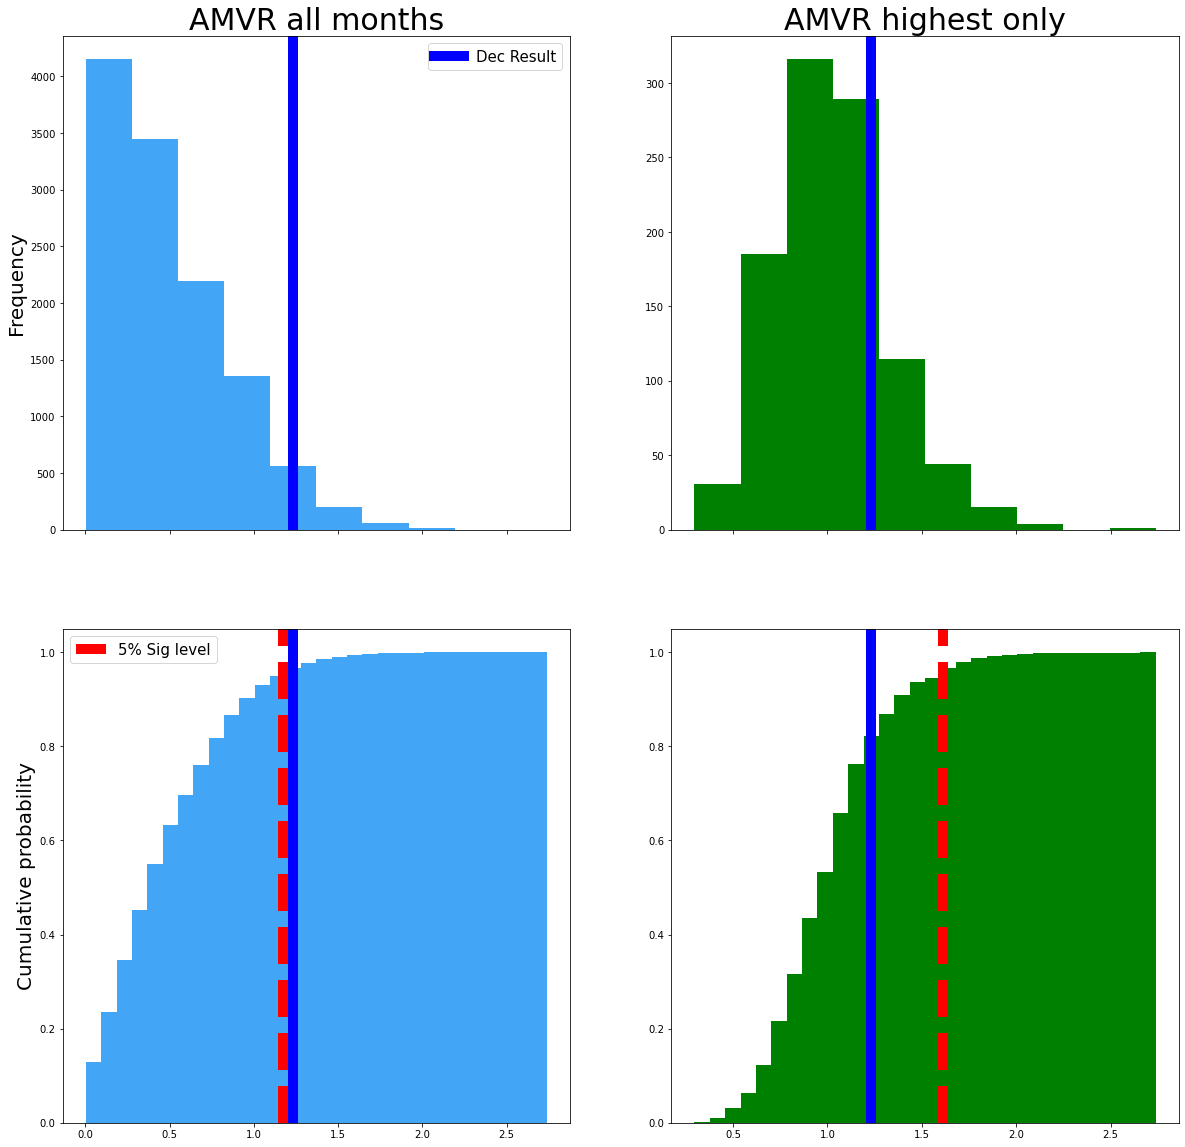

In [41]:
abs_all_months_95 = np.quantile(abs_all_months,.95)
abs_highest_95 = np.quantile(abs_highest,.95)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col',figsize=(20,20))


#plot 1
ax1.hist(abs_all_months,histtype='bar',color='#42a5f5')
ax1.set_title('AMVR all months',fontsize=30)
ax1.set_ylabel('Frequency',fontsize=20)
ax3.hist(abs_all_months,density=1,histtype='bar',cumulative=True,bins=30,color='#42a5f5')
ax3.set_ylabel('Cumulative probability',fontsize=20)
ax1.axvline(Dec_value,color='b',label='Dec Result',lw=10)
ax3.axvline(Dec_value,color='b',lw=10)
ax3.axvline(abs_all_months_95,color='r',ls='--',label='5% Sig level',lw=10)


#plot2
ax2.hist(abs_highest,histtype='bar',color='g')
ax2.set_title('AMVR highest only',fontsize=30)
ax2.axvline(Dec_value,color='b',lw=10)
ax4.hist(abs_highest,density=1,histtype='bar',cumulative=True,bins=30,color='g')
ax4.axvline(Dec_value,color='b',lw=10)
ax4.axvline(abs_highest_95,color='r',ls='--',lw=10)

ax1.legend(fontsize=15)
ax3.legend(fontsize=15)


We have learned that hypothesis testing is not the big scary beast we thought it was. Simply follow the 3 steps above to construct your model for any kind of data or test statistic.

We’ve shown that asking the right question is vital for scientific analysis. A slight change in the wording can lead to a very different model with very different results.

Hopefully, the power of the more intermediate Python functionality and it's ability to empower you to conduct statistical testing is now apparent! With just a few lines of code, we have constructed and tested a real-world phenomena and been able to draw actionable conclusions.

We discussed the importance of recognizing and correcting for multiple comparison bias and avoiding the pitfalls of p-hacking and showed how a seemingly significant result could become non-significant.

With more and more ‘big data’ along with academic pressure to produce a research paper with ‘novel’ findings or political pressure to show a result as being ‘significant’, the temptation for p-hacking is ever increasing. By learning to recognize when we are guilty of it and correcting for it accordingly, we can become better researchers and ultimately produce more accurate and therefore actionable scientific results!
